# Single region analysis

This notebook provides an example of a full processing and analysis pipeline for a single region dataset.

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import numpy as np
import pandas as pd
from IPython.utils import io
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack
from filters import KalmanDenoiser
from interpolators import StackInterpolator, NoInterpolator
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Logger level
logger.setLevel(logging.INFO)

## Parameters

### Input & output directories

In [3]:
dataroot = get_data_root()  # Root directory for raw data
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')  # Directory for output figures
logger.info(f'input data root: "{dataroot}"')
logger.info(f'output figures directory: "{figsdir}"')
figs = {}  # Figures dictionary

 10/05/2022 12:40:12: input data root: "/Users/tlemaire/Documents/data/yiyuan/raw"
 10/05/2022 12:40:12: output figures directory: "/Users/tlemaire/Documents/data/yiyuan/figs/"


### Input dataset parameters

In [4]:
mouseline = 'line3'  # mouse line
mouseid = 'mouse12'  # mouse number
region = 'region1'  # brain region 
expdate = '11122019'  # experiment date

In [5]:
# Extract input data directory 
datadir = os.path.join(dataroot, mouseline, expdate, mouseid, region)
logger.info(f'input data directory: "{datadir}"')

# Extract figures prefix
figsprefix = f'{mouseline}{mouseid}{region}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
jupyter_slack.notify_self(s)
logger.info(s)

 10/05/2022 12:40:12: input data directory: "/Users/tlemaire/Documents/data/yiyuan/raw/line3/11122019/mouse12/region1"
 10/05/2022 12:40:12: notebook started on 2022-05-10 at 12:40:12


### Input summary table figure

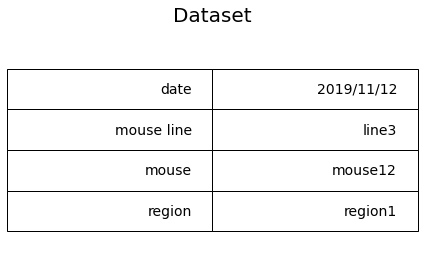

In [6]:
figs['dataset_info'] = plot_table({
    'date': f'{expdate[4:]}/{expdate[:2]}/{expdate[2:4]}',
    'mouse line': mouseline,
    'mouse': mouseid,
    'region': region
    })

### Intermediate data inspection

In [7]:
irun_inspect = None  # run index
nROIs_inspect = 3  # number of ROIs to look at for the inspection run (if specified)
irun_eq = None  # equivalent run index from suite2p output 
stacktitle = f'run {irun_inspect}'  # default stack title
stackdict = None  # empty stacks dictionary
runbounds = None  # empty runbounds array
istimframes_stacked = None  # empty stimulus frames array
save_gifs = False  # whether to save gifs of extracted movies or not

## Pre-processing (stacking, substitution, denoising)

### Gather data folders & extract acquisition settings

In [8]:
# Get raw list of subolders containing tifs
tif_folders = get_data_folders(datadir, exclude_patterns=['MIP', 'References', 'incomplete'], include_patterns=[mouseline])
tif_folders_str = '\n'.join([f'  - {os.path.basename(x)}' for x in tif_folders])
logger.info(f'Identified folders containing TIF files:\n{tif_folders_str}')

# Extract acquisition settings from each run
logger.info('extracting aquisition settings...')
daq_settings = parse_aquisition_settings(tif_folders)
daq_settings

 10/05/2022 12:40:13: /Users/tlemaire/Documents/data/yiyuan/raw/line3/11122019/mouse12/region1
 10/05/2022 12:40:13: Identified folders containing TIF files:
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860
  - line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862
  - line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-865
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-861
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-858
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-863
  - line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-867
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-857
  - line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-868
  - line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-864
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-859
  - line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-866
 10/05/2022 12:40:13: extractin

{'activeMode': 'Galvo',
 'bitDepth': 12.0,
 'currentScanAmplitude': {'XAxis': 7.6, 'YAxis': -7.6},
 'currentScanCenter': {'XAxis': 0.0, 'YAxis': 0.0},
 'daq': ('10x', 'Gain10'),
 'dwellTime': 2.8,
 'framePeriod': 0.280453201144955,
 'interlacedScanTrackCount': 0.0,
 'laserPower': (311.0, 'Pockels'),
 'laserWavelength': (920.0, 'Insight'),
 'linesPerFrame': 256.0,
 'maxVoltage': {'XAxis': 3.19540637796412, 'YAxis': -3.19540637796412},
 'micronsPerPixel': 1.96865654688785,
 'minVoltage': {'XAxis': -3.19540637796412, 'YAxis': 3.19540637796412},
 'objectiveLens': 'Olympus 10X',
 'objectiveLensMag': 10.0,
 'objectiveLensNA': 1.0,
 'opticalZoom': 2.37841423000544,
 'pixelsPerLine': 256.0,
 'pmtGain': {'PMT 1 HV': 0.0, 'PMT 2 HV': 394.7021276596, 'PMT 3 HV': 0.0},
 'positionCurrent': {'XAxis': 1.11, 'YAxis': 2.06, 'ZAxis': 0.05},
 'preampFilter': ('Filter1250KHz', '1.25 MHz'),
 'preampGain': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'preampOffset': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'rasters

### Merge TIFs into stack

In [9]:
# Generate stacks for all TIF folders in the input data directory
raw_stack_fpaths = []
nframes_per_run = []
for tif_folder in tif_folders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpath, stack_shape = stack_tifs(tif_folder, overwrite=False, full_output=True)
        raw_stack_fpaths.append(stack_fpath)
        nframes_per_run.append(stack_shape[0])

# Extract number of runs
nruns = len(raw_stack_fpaths)
logger.info(f'number of runs: {nruns}')

# Extract and check consistency of number of frames per run
nframes_per_run = list(set(nframes_per_run))
assert len(nframes_per_run) == 1, f'Differing stack lengths: {nframes_per_run}'
nframes_per_run = nframes_per_run[0]
logger.info(f'number of frames per run: {nframes_per_run}')

# Deduce number of trials per run
logger.info(f'number of frames per trial: {NFRAMES_PER_TRIAL}')
ntrials_per_run = nframes_per_run // NFRAMES_PER_TRIAL
logger.info(f'number of trials per run: {ntrials_per_run}')

# Define indexes of stimulation frames for a run
i_stim_frames_run = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load stack
    raw_stack = loadtif(raw_stack_fpaths[irun_inspect])

    # Plot stack summary frames
    figs[f'raw_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        raw_stack, title=f'run {irun_inspect} - raw stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot stack histogram
    figs[f'raw_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw': raw_stack}, title=f'run {irun_inspect} - raw stack')

    # Plot stack frequency spectrum
    figs[f'raw_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
        {'raw': raw_stack},  1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - raw stack')

    # Plot time course of the stack spatial average
    figs[f'raw_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        {'raw': raw_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - raw stack')

    # View stack
    stackdict = {'raw': raw_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run)

 10/05/2022 12:40:15: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 10/05/2022 12:40:15: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 10/05/2022 12:40:16: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 10/05/2022 12:40:16: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 10/05/2022 12:40:16: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif" already exists
 10/05/2022 12:40:16: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-865.

### Substitute stimulation frames

Since stimulation frames are highly polluted by stimulation-evoked noise, we substitute them by artificial frames estimated via spline interpolation of the preceding baseline frames.

For now, we only perform a zero order interpolation, meaning that the preceding frame use use as the estimate of the stimulus frame

In [10]:
# Define interpolator object
si = StackInterpolator(order=0, npast=2)

# Substitute stim frames every TIF stack and save outputs in specific directory 
input_root = 'stacked'
substituted_stack_fpaths = process_and_save(
    si, raw_stack_fpaths, input_root, i_stim_frames_run, overwrite=False)

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load interpolated stack for the same run
    subsituted_stack = loadtif(substituted_stack_fpaths[irun_inspect])

    # Plot interpolated stack summary frames
    figs[f'interp_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        subsituted_stack, title=f'run {irun_inspect} - {si} substituted stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot stack histogram
    figs[f'interp_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw': raw_stack, 'substituted': subsituted_stack},
        title=f'run {irun_inspect} - stacks comparison')

    # Plot stack frequency spectrum
    figs[f'interp_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
            {'raw': raw_stack, 'substituted': subsituted_stack},
            1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    figs[f'interp_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw': raw_stack_fpaths[irun_inspect],
        'substituted': substituted_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw and inteprolated stacks side-by-side
    stackdict = {
        'raw': raw_stack_fpaths[irun_inspect],
        si: substituted_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

 10/05/2022 12:40:17: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 10/05/2022 12:40:17: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 10/05/2022 12:40:17: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 10/05/2022 12:40:17: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 10/05/2022 12:40:17: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif" already exists
 10/05/2022 12:40:17: "/Users/tlemaire/D

### Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [11]:
# Define Kalman filter
kd = KalmanDenoiser(G=.5, V=0.05, npad=10)  # real filter object
# kd = NoFilter()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory
input_root = 'stacked' if isinstance(si, NoInterpolator) else si.rootcode
filtered_stack_fpaths = process_and_save(kd, substituted_stack_fpaths, input_root, overwrite=False)

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load denoised stack for the same run
    filtered_stack = loadtif(filtered_stack_fpaths[irun_inspect])

    # Plot denoised stack summary frames
    figs[f'filtered_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        filtered_stack, title=f'run {irun_inspect} - {kd} filtered stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot comparative stack histograms
    figs[f'filtered_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack},
        title=f'run {irun_inspect} - stacks comparison')

    # Plot stack frequency spectrum
    figs[f'filtered_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
            {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack},
            1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    figs[f'filtered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw, inteprolated and denoised stacks side-by-side
    stackdict = {
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        kd: filtered_stack_fpaths[irun_inspect]}
    
view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

 10/05/2022 12:40:17: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 10/05/2022 12:40:17: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 10/05/2022 12:40:17: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 10/05/2022 12:40:17: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 10/05/2022 12:40:17: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200

## Functional segmentation (suite2p)

 10/05/2022 12:40:17: parsed frame rate = 3.56 fps
 10/05/2022 12:40:17: Suite2p input directory:
/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1
 10/05/2022 12:40:17: running suite2p 0.10.2 with the following options:
{'denoise': False,
 'do_registration': 1,
 'fs': 3.56,
 'nonrigid': True,
 'reg_tif': True,
 'tau': 1.25}
 10/05/2022 12:40:17: data will be saved in suite2p base directory "suite2p_fs_3.56_reg_tif_tau_1.25"
 10/05/2022 12:40:17: found all suite2p output files in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/suite2p_fs_3.56_reg_tif_tau_1.25/plane0"
 10/05/2022 12:40:17: run options match 100% -> ignoring
 10/05/2022 12:40:17: empty data path -> no run
 10/05/2022 12:40:17: extracted data contains 880 ROIs
 10/05/2022 12:40:17: output info table corresponding to suite2p processing order:
      line  trial_length  duration (s)   fps  P 

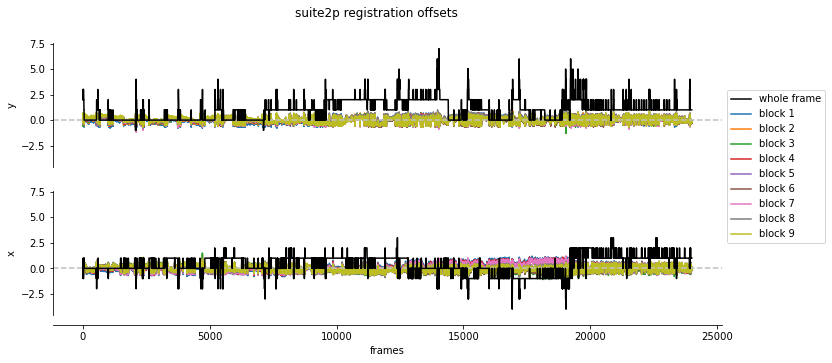

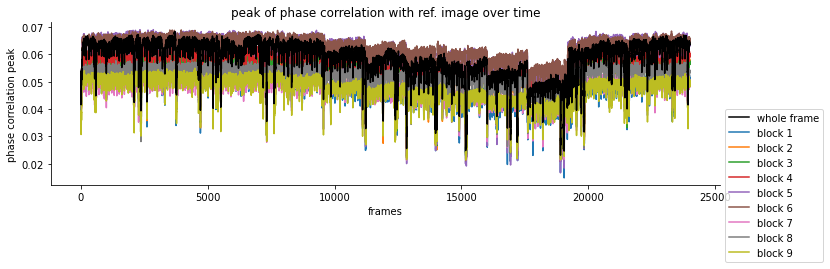

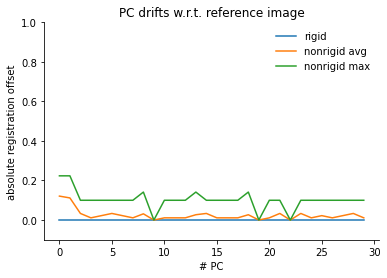

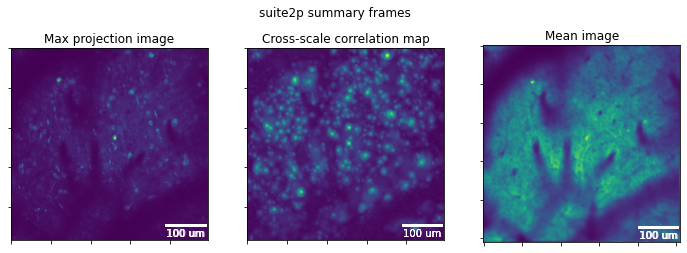

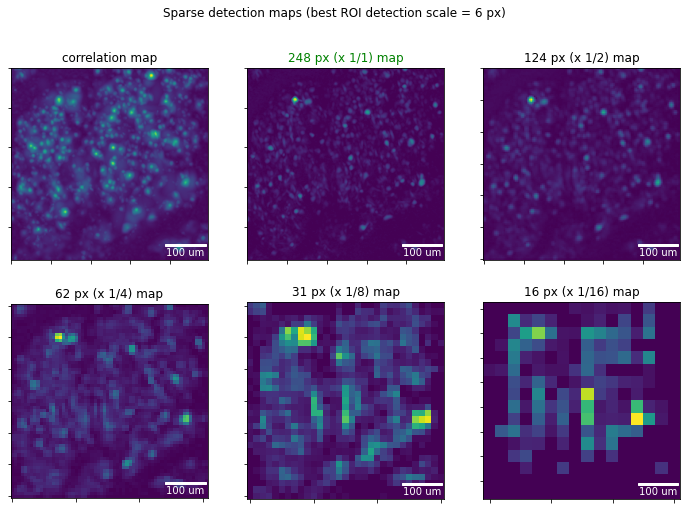

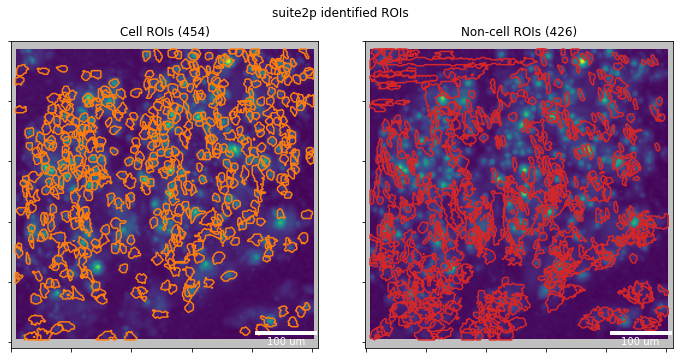

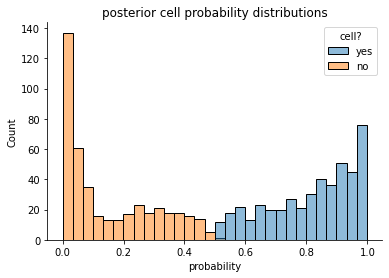

In [12]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=ntrials_per_run)
fps = get_singleton(input_info_table, Label.FPS)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

# Define suite2p custom options
ops = {
    'tau': TAU_GCAMP6S_DECAY,  # timescale of the sensor
    'fs': fps,  # sampling rate (per plane)
    'do_registration': 1,  # whether or not to perform image registration,
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': False,  # perform PCA denoising of the registered stack prior to ROI detection
}

# Run suite2p with custom options
s2p_basedir = run_s2p_and_rename(
    ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?')

# Load suite2p output data and extract options dictionary
s2p_output_fpath = os.path.join(s2p_input_dirs[0], s2p_basedir, 'plane0')
s2p_data = get_suite2p_data(s2p_output_fpath, withops=True, s2p_basedir=s2p_basedir)
s2p_ops = s2p_data.pop('ops')
outstack_label = get_s2p_stack_label(s2p_ops)

# Check that number of runs and number of frames per run extracted from suite2p output
# are consistent with suite2p inputs
nruns_out = len(s2p_ops['filelist'])
assert nruns == nruns_out, f'inconsistent number of runs between input and output: {nruns} and {nruns_out}'
del nruns_out
nframes_per_run_out = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run_out) == 1,  'inconsistent number of frames for each run in output'
nframes_per_run_out = nframes_per_run_out[0]
assert nframes_per_run == nframes_per_run_out, f'inconsistent number of frames per run between input and output: {nframes_per_run} and {nframes_per_run_out}'
del nframes_per_run_out

# Generate info table from suite2p output, and map suite2p processed file indexes
# with input files indexes (for comparative plotting purposes)
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=ntrials_per_run)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
del output_info_table['code']

# Log info table
logger.info(
    f'output info table corresponding to suite2p processing order:\n{output_info_table}')

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:

    # View output stack
    istimframes_stacked = np.tile(i_stim_frames_run, (nruns, 1))
    for i in range(nruns):
        istimframes_stacked[i] += i * nframes_per_run
    istimframes_stacked = istimframes_stacked.flatten()
    irun_eq = output_to_input_mapping[irun_inspect]
    runbounds = [nframes_per_run * irun_eq, nframes_per_run * (irun_eq + 1) - 1]
    stackdict = s2p_ops
    stacktitle = f'{outstack_label} stack (run {irun_inspect} -> output {irun_eq})'
    registered_stack = get_s2p_stack(s2p_ops, bounds=runbounds)

    # Plot stack histogram
    figs[f'registered_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack, outstack_label: registered_stack},
        title=f'run {irun_inspect} - stacks comparison')
    
    # Plot stack frequency spectrum
    figs[f'registered_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack, outstack_label: registered_stack},
        1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    # That is a good opportunity to check that our mapping of input stacks
    # to suite2p output stacks is correct.
    fig = plot_stack_timecourse({
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        },
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')
    figs[f'registered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        s2p_ops, title=outstack_label, bounds=runbounds, ax=fig.axes[0])

# Plot registration offsets over time
figs['registered_offsets'] = plot_suite2p_registration_offsets(
    s2p_ops, title='suite2p registration offsets')

# Plot registration quality metrics (phase correlation peak & PC drifts)
figs['phasecorrpeak_over_time'] = plot_suite2p_phase_corr_peak(s2p_ops)
figs['PCdrifts'] = plot_suite2p_PC_drifts(s2p_ops)

# Plot suite2p summary images
figs['registered_images'] = plot_suite2p_registration_images(
    s2p_ops, title='suite2p summary frames', um_per_px=daq_settings['micronsPerPixel'])

# Plot sparse detection maps
figs['sparse_maps'] = plot_suite2p_sparse_maps(
    s2p_ops, um_per_px=daq_settings['micronsPerPixel'])

# Plot detected ROIs on FOV
figs['identified_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='suite2p identified ROIs',
    um_per_px=daq_settings['micronsPerPixel'], mode='contour')

# Plot posterior cell probabilities for all ROIs 
figs['ROI_prob_dists'] = plot_suite2p_ROI_probs(s2p_data['iscell'])

view_stack(stackdict, title=stacktitle, bounds=runbounds, ilabels=istimframes_stacked)

## Post-processing: from raw F traces to ΔF/F and Z(ΔF/F) traces

### Load processed data if available

In [13]:
postpro_outdir = get_output_equivalent(datadir, 'raw', 'processed')
is_postpro_data_available = check_timeseries_data(postpro_outdir, nruns)
if is_postpro_data_available:
    logger.info('loading data...')
    xtimeseries, output_info_table, ROI_masks = load_timeseries_data(postpro_outdir, nruns)
    logger.info(f'experiment info table:\n{output_info_table}')
    logger.info(f'processed timeseries: {describe_dataframe_index(xtimeseries)} dataframe')
    logger.info(f'ROI masks: {describe_dataframe_index(ROI_masks)} dataframe')

 10/05/2022 12:40:22: processed timeseries data is available in "/Users/tlemaire/Documents/data/yiyuan/processed/line3/11122019/mouse12/region1" directory
 10/05/2022 12:40:22: loading data...
 10/05/2022 12:40:22: loading experiment info table...
 10/05/2022 12:40:22: loading processed timeseries data for 15 runs...


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


 10/05/2022 12:40:26: re-organizing timeseries index...
 10/05/2022 12:40:30: loading ROI masks...
 10/05/2022 12:40:30: data successfully loaded
 10/05/2022 12:40:30: experiment info table:
      line  trial_length  duration (s)   fps  P (MPa)  DC (%)  run ID  ntrials
run                                                                           
0    line3           100           0.2  3.56     0.00    50.0     869       16
1    line3           100           0.2  3.56     0.10    50.0     867       16
2    line3           100           0.2  3.56     0.20    50.0     866       16
3    line3           100           0.2  3.56     0.40    50.0     865       16
4    line3           100           0.2  3.56     0.05    50.0     868       16
5    line3           100           0.2  3.56     0.60    50.0     864       16
6    line3           100           0.2  3.56     0.80     5.0     860       16
7    line3           100           0.2  3.56     0.80    10.0     859       16
8    line3         

### Get fluorescence timeseries data

In [14]:
%%skip $is_postpro_data_available

# Get fluorescence timeseries
raw_timeseries = arrays_to_dataframe({
    Label.F_ROI: s2p_data['F'],
    Label.F_NEU: s2p_data['Fneu']},
    dim_names=[Label.ROI, Label.FRAME])
logger.info(f'assembled ({describe_dataframe_index(raw_timeseries)}) fluorescence timeseries dataframe')

# Split the data into separate runs
run_delimiters = np.arange(nruns + 1) * nframes_per_run
raw_timeseries = separate_runs(raw_timeseries, nruns)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(raw_timeseries)}) form')

# Split the data into separate trials
stim_delimiters = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM
raw_timeseries = separate_trials(raw_timeseries, ntrials_per_run)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(raw_timeseries)}) form')

# Filter out non-cell ROIs
logger.info('discarding non-cell ROIs...')
iscell = s2p_data['iscell'][:, 0]
icells = np.flatnonzero(iscell)
raw_timeseries = raw_timeseries.loc[(icells)]
s2p_data = filter_s2p_data(s2p_data, icells)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

# Discard outliers based on morphological properties (if specified)
from constants import NPIX_RATIO_THR
if NPIX_RATIO_THR is not None:
    # Plot ratio of (# pixels in the whole ROI) / (# pixels in its soma) for each ROI
    # and identify outlier ROIs
    logger.info('identifying outliers based on # pixels ratio...')
    figs['npix_ratio'], df_outliers = plot_npix_ratio_distribution(
        s2p_data['stat'], thr=NPIX_RATIO_THR)
    df_outliers[Label.ROI] = icells
    df_outliers = df_outliers.set_index(Label.ROI)
    ioutliers = np.flatnonzero(df_outliers['is_outlier'])

    # Discard outliers from data
    logger.info('updating dataset...')
    ivalids = np.flatnonzero(~df_outliers['is_outlier'])
    raw_timeseries = raw_timeseries.loc[(df_outliers.iloc[ivalids].index)]
    s2p_data = filter_s2p_data(s2p_data, ivalids)
    logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

    # Plot filtered ROIs map
    figs['filtered_ROIs'] = plot_suite2p_ROIs(
        s2p_data, s2p_ops, title='filtered suite2p ROIs',
        um_per_px=daq_settings['micronsPerPixel'], superimpose=True)

    # Log identified outliers
    logger.info(f'identified {len(ioutliers)} outlier(s):')
    df_outliers.iloc[ioutliers]

# Extract max F_ROI value of each ROI across time
F_ROI_max = raw_timeseries[Label.F_ROI].groupby(Label.ROI).max().rename(Label.MAX_F_ROI)
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Identify invalid ROIs with zero F_ROI range 
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Plot histogram distribution of max F_ROI across ROIs
fig, ax = plt.subplots()
ax.set_title(f'max {Label.F_ROI} distribution across ROIs')
sns.despine(ax=ax)
sns.histplot(df_invalids, x=Label.MAX_F_ROI, hue='is_invalid', bins=50, ax=ax)

# Discard invalid ROIs from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_invalids['is_invalid'])
raw_timeseries = raw_timeseries.loc[(df_invalids.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

# Plot filtered ROIs map
figs['filtered_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='filtered suite2p ROIs',
    um_per_px=daq_settings['micronsPerPixel'], superimpose=True)

# Plot fluorescence traces for all selected ROIs 
figs['F_ROI_traces_allROIs'] = plot_all_ROIs(raw_timeseries, Label.F_ROI)

# Log identified invalids
logger.info(f'identified {len(iinvalids)} invalid ROI(s):')
df_invalids.iloc[iinvalids]

# Select subset of ROIs to plot
iROIs = raw_timeseries.index.unique(level=Label.ROI)
if nROIs_inspect > 0:
    iROI_inspect = np.random.choice(iROIs, size=nROIs_inspect)
    iROI_inspect.sort()  # sort ROIs subset to ensure consistent looping
    logger.info(f'randomly selecting {len(iROI_inspect)} ROI(s) for plotting (index(es) = {iROI_inspect})')

    # Plot longitudinal fluorescence traces for selected ROI
    figs['raw_F_traces'] = plot_traces(
        raw_timeseries[[Label.F_ROI, Label.F_NEU]], ylabel=Label.F,
        iROI=iROI_inspect, delimiters=run_delimiters)

### Compute neuropil-corrected fluorescence data

In [15]:
%%skip $is_postpro_data_available

# Compute ROI-specific neuropil coefficients minimizing specific cost function
from constants import ALPHA
nROIs = len(raw_timeseries.index.unique(Label.ROI))
costfunc = force_positive_Fc(center_around(ALPHA))
alpha_bounds = (0.2, 2)
logger.info(f'computing alphas minimizing {costfunc.__name__} function within {alpha_bounds} interval...')
with tqdm(total=nROIs - 1, position=0, leave=True) as pbar:
    alphas = raw_timeseries.groupby(Label.ROI).apply(
        pbar_update(lambda x: optimize_alpha(x, costfunc, bounds=alpha_bounds), pbar))
alphas = alphas.rename(Label.ALPHA)

# Plot resulting distribution of neuropil subtraction coefficients
figs['alphas'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('distribution of optimal alphas across ROIs')
sns.histplot(alphas.to_frame(), x=Label.ALPHA, ax=ax, bins=30)

# Subtract neuropil background fluorescence for each ROI of interest
logger.info(f'subtracting neuropil background...')
raw_timeseries[Label.F] = raw_timeseries[Label.F_ROI] - alphas * raw_timeseries[Label.F_NEU]

if nROIs_inspect > 0:
    # Plot longitudinal fluorescence traces for selected ROI
    alphas_plt = alphas.loc[iROI_inspect].groupby(Label.ROI).first()
    figs['F_trace'] = plot_traces(
        raw_timeseries[[Label.F]],
        iROI=iROI_inspect, delimiters=run_delimiters,
        title=[f'{Label.ALPHA} = {a:.2f}' for a in alphas_plt])
    if irun_eq is not None:
        # Highlight selected run on figure
        for ax in figs['F_trace'].axes:
            ax.axvspan(run_delimiters[irun_eq], run_delimiters[irun_eq + 1], color='silver', alpha=0.5)

# Plot corrected fluorescence for all ROIs
figs['F_traces_allROIs'] = plot_all_ROIs(raw_timeseries, Label.F)

### Baseline computation & correction

The baseline of fluorescence signals is computed by applying consecutively (1) a low percentile sliding window and (2) an average sliding window, over the entire fluorescence timecourse. This is performed independently for each cell (obviously) but also for each run owing to potential discontinuities in acquisition conditions across runs (especially since the stacking order of these runs does not necessarily follow the original chronological order of acquisition).

For downstream analysis steps, we wish to consider only cells who exhibit a relatively flat activity baseline. Therefore, at this point we discard any cell whose baseline fluctuations are above a certain threshold. Since baseline fluorescence levels vary significantly across cells, we use a relative metrics (relative standard deviation RSD) to evaluate fluctuations of the baseline around its mean, and discard cells whose baseline RSD is above some defined threshold for any of the acquisition runs.

The remaining fluorescence signals are corrected by subtraction of a mean-corrected time-varying baseline.

In [16]:
%%skip $is_postpro_data_available

from constants import BASELINE_WLEN, BASELINE_QUANTILE, BASELINE_RSD_THR
raw_timeseries[Label.F0] = compute_baseline(
    raw_timeseries[Label.F], fps, BASELINE_WLEN, BASELINE_QUANTILE)

# Plot original and baseline fluorescence of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'F_F0_trace_run{irun_inspect}'] = plot_traces(
        raw_timeseries[[Label.F, Label.F0]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters,
        title=f'w = {BASELINE_WLEN:.1f} s, q = {BASELINE_QUANTILE * 1e2:.1f} %')

# Compute F0 relative standard deviation for each ROI and run
logger.info('computing baseline relative standard deviation...')
F0_RSD_per_run = raw_timeseries[Label.F0].groupby([Label.ROI, Label.RUN]).agg(
    lambda x: np.nanstd(x) / np.abs(np.nanmean(x)))

# Identify outliers as ROIs whose max RSD across runs is above defined threshold
logger.info('identifying outliers...')
F0_RSD_max = F0_RSD_per_run.groupby(Label.ROI).max()
is_outlier = (F0_RSD_max > BASELINE_RSD_THR)
df_outliers = pd.DataFrame({'max F0 RSD': F0_RSD_max, 'is_outlier': is_outlier})
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Plot RSD distribution per ROI & run amongst remaining ROIs
ax = sns.heatmap(
    F0_RSD_per_run.drop(df_outliers.iloc[ioutliers].index).unstack(),
    vmin=0, cmap='viridis')
ax.set_title('F0 RSD distribution per ROI & run')

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
raw_timeseries = raw_timeseries.loc[(df_outliers.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence dataframe')

# Mean correction of remaining signals
logger.info('subtracting mean-corrected baseline from signals...')
# Compute mean baseline value per ROI & run
F0_mean = raw_timeseries[Label.F0].groupby([Label.ROI, Label.RUN]).mean()
# Apply baseline corretor to both fluorescence and baseline signals
baseline_corrector = raw_timeseries[Label.F0] - F0_mean
raw_timeseries[Label.F] -= baseline_corrector
raw_timeseries[Label.F0] -= baseline_corrector

# Plot baseline-corrected fluorescence signal and baseline of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'F_F0_trace_run{irun_inspect}_corrected'] = plot_traces(
        raw_timeseries[[Label.F, Label.F0]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters,
        title='after baseline correction')

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

### ΔF/F0 computation

In [17]:
%%skip $is_postpro_data_available

# Compute relative change in fluorescence
logger.info('computing relative change in fluorescence...')
F0 = raw_timeseries[Label.F0].groupby([Label.ROI, Label.RUN]).median()  # median of the baseline over each run
raw_timeseries[Label.DFF] = (raw_timeseries[Label.F] - F0) / F0

# Plot consecutive trials of relative fluorescence change of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'dFF_trace_run{irun_inspect}'] = plot_traces(
        raw_timeseries[[Label.DFF]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)

### Z(ΔF/F0) computation

In [18]:
%%skip $is_postpro_data_available

# Fit gaussians to dFF histogram distributions
logger.info('fitting gaussians to dFF histogram distributions...')
nROIs, nruns = [len(raw_timeseries.index.unique(k)) for k in [Label.ROI, Label.RUN]]
with tqdm(total=nROIs * nruns - 1, position=0, leave=True) as pbar:
    dFF_histfits = raw_timeseries[Label.DFF].groupby([Label.ROI, Label.RUN]).agg(
        pbar_update(nan_proof(gauss_histogram_fit), pbar))
nbins = dFF_histfits.iloc[0][0].size
logger.info('extracting fitted gaussian parameters...')
dFF_histparams = dFF_histfits.apply(lambda x: x[1])
dFF_histparams = pd.DataFrame(
    dFF_histparams.tolist(),
    columns=['H', 'A', 'x0', 'sigma'],
    index=dFF_histparams.index)

# Plot distributions of the relevant extracted Gaussian parameters
figs['gaussianfits_dists'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('dFF Gaussian fit parameters distributions')
sns.scatterplot(data=dFF_histparams, x='x0', y='sigma', ax=ax)

# Plot dFF histogram distribution and fitted gaussian parameters for each ROI of interest 
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'dFF_hist_fits_run{irun_inspect}'] = plot_gaussian_histogram_fit(
        raw_timeseries, dFF_histparams, iROI_inspect, irun_eq, nbins=nbins)

# Normalize dFF traces by gaussian parameters to obtain dFF z-scores
logger.info('normalizing dFF by gaussian parameters to compute z-scores...')
raw_timeseries[Label.ZSCORE] = (
    raw_timeseries.loc[:, Label.DFF] - dFF_histparams['x0']) / dFF_histparams['sigma']

# Plot consecutive trials of dFF z-score of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'zscore_trace_run{irun_inspect}'] = plot_traces(
        raw_timeseries[[Label.ZSCORE]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    for ax in figs[f'zscore_trace_run{irun_inspect}'].axes:
        ax.axhspan(- 1, 1, fc='silver', ec=None, alpha=0.5);

### Save ΔF/F and Z(ΔF/F) traces

In [19]:
%%skip $is_postpro_data_available

# Reduce timeseries data to dff and z-scores only
xtimeseries = raw_timeseries.loc[:, [Label.DFF, Label.ZSCORE]]
# Gather ROI masks information in dataframe
ROI_masks = get_ROI_masks(s2p_data['stat'], xtimeseries.index.unique(level=Label.ROI))
# Save data in output directory
save_timeseries_data(xtimeseries, output_info_table, ROI_masks, postpro_outdir)

## Statistics (response metrics & cell classification)

### Create statistics dataframe

<span style="color:orange">NOTE: it is very important to use the info table generated from the suite2p output options "filelist" field as the basis to populate the dataframe. This ensures that the order of parsed parameters matches the order in which suite2p processed input files, and thus the order in which the fluorescence data is arranged.</span>

In [20]:
# Get the index dimensions of the fluorescence dataset
index_dims = {k: xtimeseries.index.unique(k) for k in xtimeseries.index.names}

# Remove data from potential trials to discard
from constants import ITRIALS_DISCARD
logger.info(f'original data ({describe_dataframe_index(xtimeseries)})')
xtimeseries = discard_indexes(xtimeseries, ikey=Label.TRIAL, idiscard=ITRIALS_DISCARD)

# Create stats dataframes
logger.info('creating statistics dataframe')
stats = pd.DataFrame()

# Add potential discarded labels
logger.info('adding "discarded" labels...')
stats[Label.DISCARDED] = ~xtimeseries[Label.ZSCORE].groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).first().notna()

# Add information about pule and time-average acoustic intensity to info table
output_info_table = add_intensity_to_table(output_info_table)

# Add experimental info to stats
if Label.P not in stats:
    logger.info('adding experimental info to stats...')
    exp_output_table = repeat_along_new_dims(
        output_info_table.drop(Label.NTRIALS, axis=1),
        {k: index_dims[k] for k in [Label.ROI, Label.TRIAL]})
    exp_output_table = exp_output_table.reorder_levels(
        [Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
    stats = pd.concat([exp_output_table, stats], axis=1) 

logger.info('stats table:')
stats

 10/05/2022 12:40:31: original data (452 ROIs x 15 runs x 16 trials x 100 frames)
 10/05/2022 12:40:31: creating statistics dataframe
 10/05/2022 12:40:31: adding "discarded" labels...
 10/05/2022 12:40:31: deriving acoustic intensity information...
 10/05/2022 12:40:31: adding experimental info to stats...
 10/05/2022 12:40:32: stats table:


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  \
ROI run trial                                                             
1   0   0      line3           100           0.2  3.56      0.0    50.0   
        1      line3           100           0.2  3.56      0.0    50.0   
        2      line3           100           0.2  3.56      0.0    50.0   
        3      line3           100           0.2  3.56      0.0    50.0   
        4      line3           100           0.2  3.56      0.0    50.0   
...              ...           ...           ...   ...      ...     ...   
878 14  11     line3           100           0.2  3.56      0.8    80.0   
        12     line3           100           0.2  3.56      0.8    80.0   
        13     line3           100           0.2  3.56      0.8    80.0   
        14     line3           100           0.2  3.56      0.8    80.0   
        15     line3           100           0.2  3.56      0.8    80.0   

               run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  discarded  
ROI run trial                                                     
1   0   0         869        0.000000         0.00000      False  
        1         869        0.000000         0.00000      False  
        2         869        0.000000         0.00000      False  
        3         869        0.000000         0.00000      False  
        4         869        0.000000         0.00000      False  
...               ...             ...             ...        ...  
878 14  11        863       19.784475        15.82758      False  
        12        863       19.784475        15.82758      False  
        13        863       19.784475        15.82758      False  
        14        863       19.784475        15.82758      False  
        15        863       19.784475        15.82758      False  

[108480 rows x 10 columns]

### Visualize stimulation protocol

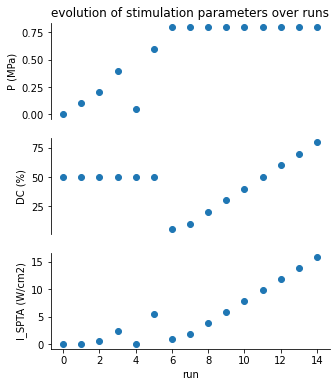

In [21]:
figs['protocol_summary'] = plot_protocol(
    output_info_table,
    xkey=Label.RUN,
    ykeys=(Label.P, Label.DC, Label.ISPTA))

### Identify & reject trials with significant stimulus-evoked motion artefact

 10/05/2022 12:40:32: computing diplacement velocity over time from registration offsets...
 10/05/2022 12:40:32: correcting displacement velocity at stimulus indexes to compensate for stimulus frames substitution...
 10/05/2022 12:40:33: identified 25 / 240 trials (10.4%) with peak displacement higher than 2.0 um/s


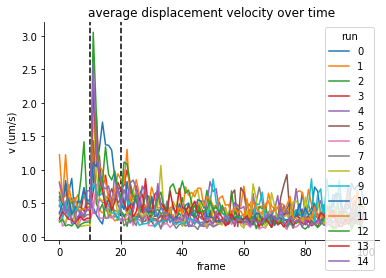

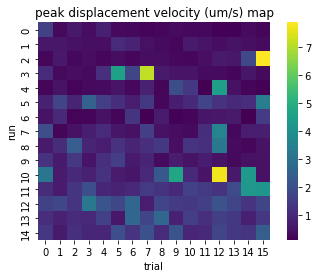

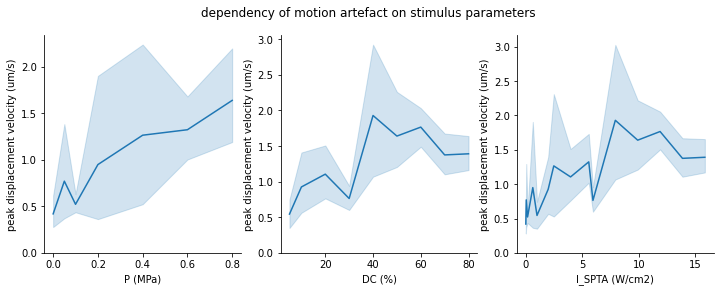

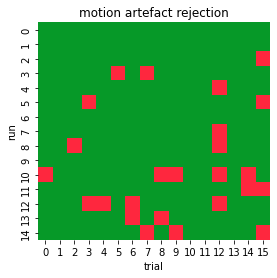

In [22]:
# Create (run, trial, frame) multi-index
exp_mux = pd.MultiIndex.from_product(
    [np.arange(nruns), np.arange(ntrials_per_run), np.arange(NFRAMES_PER_TRIAL)],
    names=[Label.RUN, Label.TRIAL, Label.FRAME])

# Compute displacement velocity profiles
is_substituted = isinstance(si, StackInterpolator)
vdisp = compute_displacement_velocity(
    s2p_ops, exp_mux, 
    daq_settings['micronsPerPixel'],
    1 / daq_settings['framePeriod'],
    substituted=is_substituted)

# Plot average displacement velocity profile for each run
figs['vdisp_profiles'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('average displacement velocity over time')
for idx in [FrameIndex.STIM, FrameIndex.RESPONSE.stop]:
    ax.axvline(idx, c='k', ls='--')
sns.lineplot(
    data=vdisp.to_frame(), x=Label.FRAME, y=vdisp.name, ax=ax,
    hue=Label.RUN, ci=None, palette='tab10')

# Compute peak of displacement velocity within response window for each run and trial
# and assess of motion exceeded threshold
from constants import VDISP_THR
vdisp_window = vdisp.loc[pd.IndexSlice[:, :, FrameIndex.RESPONSE]]
vdisp_peaks = vdisp_window.groupby([Label.RUN, Label.TRIAL]).agg(
    find_response_peak).rename(Label.PEAK_DISP_VEL)
vdisp_peaks = vdisp_peaks.to_frame()
vdisp_peaks[Label.MOTION] = vdisp_peaks[Label.PEAK_DISP_VEL] > VDISP_THR
nmotion = vdisp_peaks[Label.MOTION].sum()
ntot = len(vdisp_peaks)

# Add peak displacement velocity and motion status info to stats
exp_vdisp_peaks = repeat_along_new_dim(
    vdisp_peaks, Label.ROI, stats.index.unique(Label.ROI)
    ).swaplevel(0, 2).swaplevel(1, 2).sort_index()
stats = pd.concat([stats, exp_vdisp_peaks], axis=1)

# Add stimulus parameters info to vdisp peaks dataframe
vdisp_peaks = pd.concat([vdisp_peaks, repeat_along_new_dim(
    output_info_table[[Label.P, Label.DC, Label.ISPTA]],
    Label.TRIAL, exp_mux.unique(level=Label.TRIAL))], axis=1)

# Plot peak displacement velocity heatmap
figs['peakvdisp_map'], ax = plt.subplots()
ax.set_aspect(1.)
ax.set_title(f'{Label.PEAK_DISP_VEL} map')
sns.heatmap(vdisp_peaks[Label.PEAK_DISP_VEL].unstack(), ax=ax, cmap=nan_viridis)

# Plot dependency of motion artefact on pressure & duty cycle 
figs['peakvdisp_vs_stimparams'], axes = plt.subplots(1, 3, figsize=(12, 4))
figs['peakvdisp_vs_stimparams'].suptitle('dependency of motion artefact on stimulus parameters')
for ax, xkey in zip(axes, [Label.P, Label.DC]):
    sns.lineplot(
        data=get_xdep_data(vdisp_peaks, xkey), x=xkey, y=Label.PEAK_DISP_VEL, ax=ax)
sns.lineplot(data=vdisp_peaks, x=Label.ISPTA, y=Label.PEAK_DISP_VEL, ax=axes[-1])
for ax in axes:
    sns.despine(ax=ax)
    ax.set_ylim(0, ax.get_ylim()[1])

# Plot motion artefact rejection heatmap
figs['motionreject_map'], ax = plt.subplots()
ax.set_title('motion artefact rejection')
ax.set_aspect(1.)
sns.heatmap(vdisp_peaks[Label.MOTION].unstack(), ax=ax, cmap=rdgn, cbar=False)

# Log identified motion trials
logger.info(
    f'identified {nmotion} / {ntot} trials ({nmotion / ntot * 1e2:.1f}%)'
    f' with peak displacement higher than {VDISP_THR} um/s')

### Identify & reject trials with pre-stimulus activity

 10/05/2022 12:40:33: analyzing Z(ΔF/F0) levels in pre-stimulus intervals...
 10/05/2022 12:40:33: removing samples labeled as "discarded"...
 10/05/2022 12:40:33: identified 12383/108480 trials (11.4 %) with significant pre-stimulus activity
 10/05/2022 12:40:36: identified 15/240 trials (6.2%) with more than 50.0 % pre-active cells


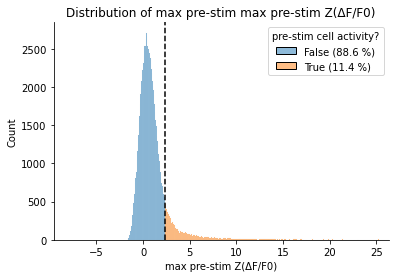

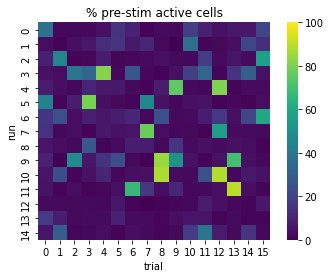

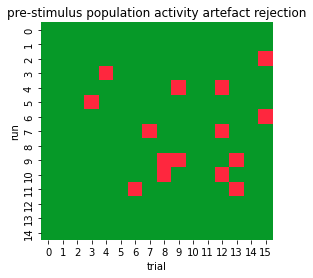

In [23]:
# Determine variable used to asses pre-stimulus activity
ykey_prestim = Label.ZSCORE
ykey_prestim_max = f'max pre-stim {ykey_prestim}'
from constants import PTHR_DETECTION
ythr_prestim = {
    Label.DFF: 0.25,
    Label.ZSCORE: pvalue_to_zscore(PTHR_DETECTION),
}[ykey_prestim]

# Identify max in pre-stimulus window for each trial
logger.info(f'analyzing {ykey_prestim} levels in pre-stimulus intervals...')
y_prestim = xtimeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.PRESTIM], ykey_prestim]
stats[ykey_prestim_max] = y_prestim.groupby([Label.ROI, Label.RUN, Label.TRIAL]).max()

# Classify pre-stimulus state on a per-ROI basis for each trial
stats[Label.PRESTIM_ACTIVITY] = stats[ykey_prestim_max] > ythr_prestim
npreacts, ntot = stats[Label.PRESTIM_ACTIVITY].sum(), len(included(stats))
pcts = {True: npreacts / ntot * 100, False: (ntot - npreacts) / ntot * 100}
logger.info(
    f'identified {npreacts}/{ntot} trials ({pcts[True]:.1f} %) with '
    'significant pre-stimulus activity')

# Plot histogram distribution of pre-stimulus dFF z-score
figs['prestim max dist'], ax = plt.subplots()
sns.despine(ax=ax)
ax = sns.histplot(stats, x=ykey_prestim_max, hue=Label.PRESTIM_ACTIVITY, ax=ax)
ax.axvline(ythr_prestim, ls='--', c='k')
ax.set_xlim(
    ax.get_xlim()[0],
    stats[ykey_prestim_max].median() + 10 * stats[ykey_prestim_max].std())
ax.set_title(f'Distribution of max pre-stim {ykey_prestim_max}')
leg = ax.get_legend()
for t in leg.texts:
    cond = t.get_text() == 'True'
    t.set_text(f'{cond} ({pcts[cond]:.1f} %)')

# Compute and plot fraction of ROIs with pre-stimulus activity for each run & trial
nROIs = len(stats.index.unique(level=Label.ROI))
npreacts_per_run_trial = stats.loc[:, Label.PRESTIM_ACTIVITY].groupby(
    [Label.RUN, Label.TRIAL]).sum()
isdiscarded = stats[Label.DISCARDED].groupby([Label.RUN, Label.TRIAL]).first()
npreacts_per_run_trial.loc[isdiscarded[isdiscarded].index] = np.nan
pct_preacts_per_run_trial = (npreacts_per_run_trial / nROIs * 1e2).rename(Label.PCT_PREACTIVE_CELLS)
figs['pct_prestim_activity_map'], ax = plt.subplots()
ax.set_aspect(1.)
ax.set_title(Label.PCT_PREACTIVE_CELLS)
sns.heatmap(pct_preacts_per_run_trial.unstack(), ax=ax, vmin=0, vmax=100, cmap=nan_viridis)

# Label trials with large fraction of pre-active cells
from constants import PCT_PREACTIVE_THR
pop_preact_per_run_trial = (pct_preacts_per_run_trial > PCT_PREACTIVE_THR).rename(
    Label.PRESTIM_POP_ACTIVITY)
npreacts_pop, ntot = pop_preact_per_run_trial.sum(), len(pop_preact_per_run_trial)
pcts = {True: npreacts_pop / ntot * 100, False: (ntot - npreacts_pop) / ntot * 100}
logger.info(
    f'identified {npreacts_pop}/{ntot} trials ({pcts[True]:.1f}%)'
    f' with more than {PCT_PREACTIVE_THR} % pre-active cells')
exp_pop_preact_per_run_trial = repeat_along_new_dim(
    pop_preact_per_run_trial.to_frame(),
    Label.ROI, stats.index.unique(level=Label.ROI)).reorder_levels(
    [Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
stats[Label.PRESTIM_POP_ACTIVITY] = exp_pop_preact_per_run_trial

# Plot pre-stimulus population activity rejection heatmap
figs['prestim reject map'], ax = plt.subplots()
ax.set_title('pre-stimulus population activity artefact rejection')
ax.set_aspect(1.)
sns.heatmap(pop_preact_per_run_trial.unstack(), ax=ax, cmap=rdgn, cbar=False);

### Compute average timeseries and states over valid trials

In [24]:
# Add validity labels to timeseries and selecting only valid index
logger.info('generating expanded validity indexes...')
exp_validity_labels = repeat_along_new_dim(
    stats[[Label.DISCARDED, Label.MOTION, Label.PRESTIM_ACTIVITY, Label.PRESTIM_POP_ACTIVITY]],
    Label.FRAME, xtimeseries.index.unique(level=Label.FRAME))

# Restrict timeseries to valid trials and average over trials
logger.info('computing trial-averaged timeseries per ROI & run, over valid trials...') 
valid_xtimeseries = valid(pd.concat([xtimeseries, exp_validity_labels], axis=1))[[*xtimeseries.columns]]
trialavg_xtimeseries = valid_xtimeseries.groupby([Label.ROI, Label.RUN, Label.FRAME]).mean()

# Restrict stats to valid trials and average over them
logger.info('computing trial-averaged stats over valid trials...')
valid_stats = valid(stats)
delkeys = [
    Label.DISCARDED, Label.PEAK_DISP_VEL, Label.MOTION,
    Label.PRESTIM_ACTIVITY, Label.PRESTIM_POP_ACTIVITY]
for k in delkeys:
    del valid_stats[k]
trialavg_stats = get_trial_averaged(valid_stats)
trialavg_stats

 10/05/2022 12:40:39: generating expanded validity indexes...
 10/05/2022 12:40:43: computing trial-averaged timeseries per ROI & run, over valid trials...
 10/05/2022 12:40:44: removing samples labeled as "discarded"...
 10/05/2022 12:40:45: discarding samples with significant motion artefact...
 10/05/2022 12:40:46: discarding samples with pre-stimulus activity...
 10/05/2022 12:40:46: discarding samples with pre-stimulus population activity...
 10/05/2022 12:40:47: computing trial-averaged stats over valid trials...
 10/05/2022 12:40:47: removing samples labeled as "discarded"...
 10/05/2022 12:40:47: discarding samples with significant motion artefact...
 10/05/2022 12:40:47: discarding samples with pre-stimulus activity...
 10/05/2022 12:40:47: discarding samples with pre-stimulus population activity...


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  run ID  \
ROI run                                                                     
1   0    line3         100.0           0.2  3.56     0.00    50.0   869.0   
    1    line3         100.0           0.2  3.56     0.10    50.0   867.0   
    2    line3         100.0           0.2  3.56     0.20    50.0   866.0   
    3    line3         100.0           0.2  3.56     0.40    50.0   865.0   
    4    line3         100.0           0.2  3.56     0.05    50.0   868.0   
...        ...           ...           ...   ...      ...     ...     ...   
878 10   line3         100.0           0.2  3.56     0.80    40.0   856.0   
    11   line3         100.0           0.2  3.56     0.80    50.0   855.0   
    12   line3         100.0           0.2  3.56     0.80    60.0   861.0   
    13   line3         100.0           0.2  3.56     0.80    70.0   862.0   
    14   line3         100.0           0.2  3.56     0.80    80.0   863.0   

         I_SPPA (W/cm2)  I_SPTA (W/cm2)  max pre-stim Z(ΔF/F0)  
ROI run                                                         
1   0          0.000000        0.000000               0.555881  
    1          0.309132        0.154566               0.404224  
    2          1.236530        0.618265               0.530857  
    3          4.946119        2.473059               0.749780  
    4          0.077283        0.038642               0.153114  
...                 ...             ...                    ...  
878 10        19.784475        7.913790               0.371970  
    11        19.784475        9.892238               0.659442  
    12        19.784475       11.870685              -0.021417  
    13        19.784475       13.849133               0.522350  
    14        19.784475       15.827580               0.519597  

[6780 rows x 10 columns]

### Define metrics of interest for peak detection and classification

In [25]:
# Variable of interest
ykey_processing = Label.ZSCORE

# Derived labels and thresholds
ykey_peak = f'peak {ykey_processing}'
ykey_baseline = f'baseline {ykey_processing}'
ykey_change = f'relative {ykey_processing} change'
ythr = {Label.ZSCORE: 1, Label.DFF: 0.05}[ykey_processing]

### Compute stimulus-evoked peak

In [26]:
# Identify peak in response window for each ROI & run
trialavg_stats[ykey_peak] = detect_peaks_in_window(
    trialavg_xtimeseries, ykey_processing, FrameIndex.RESPONSE)

 10/05/2022 12:40:53: detecting peak Z(ΔF/F0) in 10-20 index window across ROIs and runs...
 10/05/2022 12:40:54: identified peaks in 6751/6780 windows (99.6 %)


### Compute signal baseline, and relative change to peak  

 10/05/2022 12:40:54: extracting mean Z(ΔF/F0) pre-stim level from trial-averaged traces...
 10/05/2022 12:40:54: computing relative Z(ΔF/F0) changes (w.r.t. pre-stim baseline)...


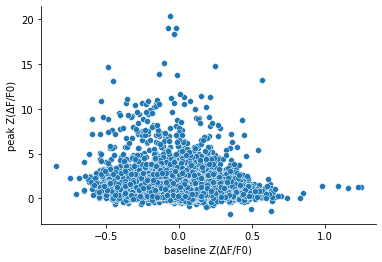

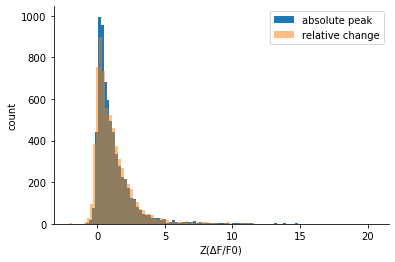

In [27]:
# Extract pre-stimulus (baseline) level
logger.info(f'extracting mean {ykey_processing} pre-stim level from trial-averaged traces...')
yprestim = trialavg_xtimeseries.loc[pd.IndexSlice[:, :, FrameIndex.PRESTIM], ykey_processing]
trialavg_stats[ykey_baseline] = yprestim.groupby(
    [Label.ROI, Label.RUN]).mean()

# Plot co-distribution of baseline and peak
figs['peak baseline codist'], ax = plt.subplots()
sns.despine(ax=ax)
sns.scatterplot(
    ax=ax, data=trialavg_stats,
    x=ykey_baseline, y=ykey_peak)

# Subtract baseline from peak to get relative increase
logger.info(f'computing relative {ykey_processing} changes (w.r.t. pre-stim baseline)...')
trialavg_stats[ykey_change] = (trialavg_stats[ykey_peak] - trialavg_stats[ykey_baseline])

# Plot absolute and relative peak histograms
figs['peak hist'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_xlabel(ykey_processing)
ax.set_ylabel('count')
ax.hist(trialavg_stats[ykey_peak], bins=100, label='absolute peak')
ax.hist(trialavg_stats[ykey_change], bins=100, alpha=0.5, label='relative change')
ax.legend();

### Compute baseline of peak detection with sliding window and subtract it to evoked peak

In [28]:
%%skip True

ykey_sliding_peak = f'sliding peak {ykey_processing}'

# Repeat procedure while sliding detection window along trial interval
logger.info('identifying peaks while sliding detection window across trial interval...')
peaks_along_trial, iseeds = slide_along_trial(
    lambda data, w: detect_peaks_in_window(data, ykey_processing, w, verbose=False),
    trialavg_xtimeseries, FrameIndex.RESPONSE, NSEEDS_PER_TRIAL)
tseeds = (iseeds - FrameIndex.STIM) / fps

# Average across runs for each ROI
logger.info('averaging across runs for each ROI')
peaks_stats = peaks_along_trial.groupby([Label.ROI, Label.ISTART]).agg(['mean', 'std'])
peaks_stats = peaks_stats.droplevel(0, axis=1).add_prefix(f'{ykey_sliding_peak} ')

# Average mean and and std across "quiet" interval
tbounds_baseline = (10, 20)  # s
is_baseline = np.logical_and(tseeds >= tbounds_baseline[0], tseeds <= tbounds_baseline[1])
ibaseline = np.where(is_baseline)[0]
ibaseline = iseeds[ibaseline]
baseline_stats = peaks_stats.loc[pd.IndexSlice[:, ibaseline], :].groupby(Label.ROI).mean()
baseline_stats = baseline_stats.add_suffix(' baseline')

# Add baseline info to trialavg stats
expand_and_add(baseline_stats, trialavg_stats)

# Plot average evolution across runs for each ROI 
figs['peak sliding window'], ax = plt.subplots()
ax.set_title(f'evolution of detected peak {ykey_processing}')
sns.despine(ax=ax)
ax.set_xlabel('starting time of detection window (s)')
ax.set_ylabel(ykey_peak)
for iROI, v in peaks_stats.groupby(Label.ROI):
    y, ystd = [v[f'{ykey_sliding_peak} {k}'].values for k in ['mean', 'std']]
    line, = ax.plot(tseeds, y)
    ax.fill_between(tseeds, y - ystd, y + ystd, alpha=0.2)
    # ax.axhline(
    #     baseline_stats.loc[iROI, f'{ykey_sliding_peak} mean baseline'], c=line.get_color())
ax.axvline(0, ls='--', c='k')
ax.axvspan(*tbounds_baseline, color='silver', alpha=0.5)

# Plot co-distribution of baseline and peak
figs['peak baseline codist'], ax = plt.subplots()
sns.despine(ax=ax)
sns.scatterplot(
    ax=ax, data=trialavg_stats,
    x=f'{ykey_sliding_peak} mean baseline', y=ykey_peak)

# Subtract baseline from peak to get relative increase
logger.info(f'computing relative {ykey_processing} changes (w.r.t. sliding baseline)...')
trialavg_stats[ykey_change] = (
    trialavg_stats[ykey_peak] - trialavg_stats[f'{ykey_sliding_peak} mean baseline'])

# Plot absolute and relative peak histograms
figs['peak hist'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_xlabel(ykey_processing)
ax.set_ylabel('count')
ax.hist(trialavg_stats[ykey_peak], bins=100, label='absolute peak')
ax.hist(trialavg_stats[ykey_change], bins=100, alpha=0.5, label='relative change')
ax.legend();

### Identify responsive conditions per ROI

 10/05/2022 12:40:54: identified 2862/6780 (42.21%) positive conditions across ROIs


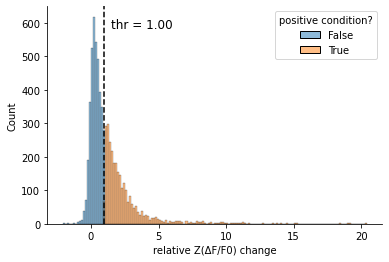

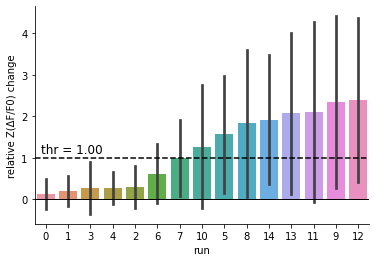

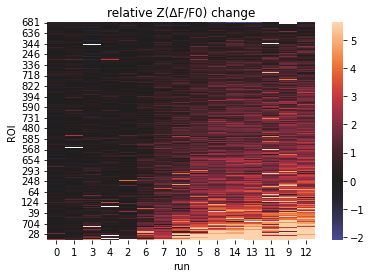

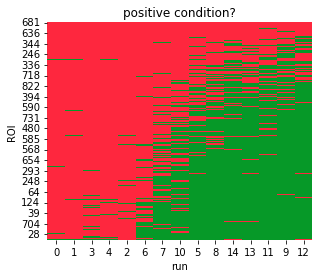

In [29]:
# Order runs and ROIs by increasing elicited peak
run_order = trialavg_stats[ykey_change].groupby(
    Label.RUN).mean().sort_values().index
ROI_order = trialavg_stats[ykey_change].groupby(
    Label.ROI).mean().sort_values().index

# For each ROI, threshold peak to identify responsive conditions
trialavg_stats[Label.POS_COND] = trialavg_stats[ykey_change] > ythr
nposconds = trialavg_stats[Label.POS_COND].sum()
nconds = len(trialavg_stats)
logger.info(
    f'identified {nposconds}/{nconds} ({nposconds / nconds * 100:.2f}%) '
    'positive conditions across ROIs')

# Plot peak histogram with condition type color code 
figs[f'peak hist per condition type'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(data=trialavg_stats, x=ykey_change, hue=Label.POS_COND)
ax.axvline(ythr, c='k', ls='--')
ax.text(
    data_to_axis(ax, (ythr, 0))[0] + .02, .9, f'thr = {ythr:.2f}',
    transform=ax.transAxes, fontsize=12)

# Plot peak vs. run
figs[f'peak vs run'], ax = plt.subplots()
sns.despine(ax=ax)
sns.barplot(
    ax=ax, data=trialavg_stats.reset_index(level=Label.RUN),
    x=Label.RUN, y=ykey_change, order=run_order, ci='sd')
# ax.set_ylim(0, ax.get_ylim()[1])
ax.axhline(ythr, c='k', ls='--')
ax.axhline(0., c='k', lw=1)
ax.text(
    .02, data_to_axis(ax, (0, ythr))[1] + .02, f'thr = {ythr:.2f}',
    transform=ax.transAxes, fontsize=12)

# Plot peak heatmap per ROI & run
figs[f'peak map'], ax = plt.subplots()
ax.set_title(ykey_change)
med = trialavg_stats[ykey_change].median()
std = trialavg_stats[ykey_change].std()
sns.heatmap(
    trialavg_stats[ykey_change].unstack().reindex(
        ROI_order, axis=0).reindex(run_order, axis=1),
    center=0., ax=ax, vmax=med + 3 * std)

# Plot positive condition binary map per ROI & run
figs['resp heatmap'], ax = plt.subplots(figsize=(4.75, 4))
ax.set_title(Label.POS_COND)
sns.heatmap(
    trialavg_stats[Label.POS_COND].unstack().reindex(
        ROI_order, axis=0).reindex(run_order, axis=1),
    ax=ax, cbar=False, cmap=gnrd);

### Identify responding cells based on their number of responsive conditions

 10/05/2022 12:40:56: identified 404/452 (89.4 %) responding cells


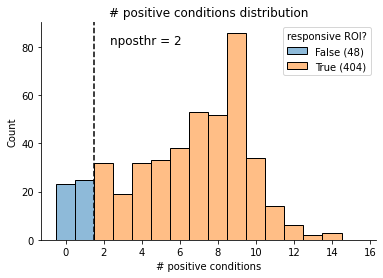

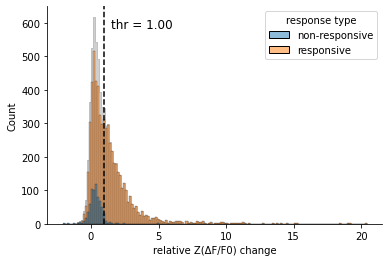

In [30]:
# Compute number of significant conditions per ROI
nposconds_per_roi = trialavg_stats[Label.POS_COND].groupby(Label.ROI).sum().rename(Label.NPOS_CONDS)
roistats = nposconds_per_roi.to_frame()

# Classify ROIs based on number of responsive conditions
from constants import NPOSCONDS_THR
roistats[Label.IS_RESP_ROI] = nposconds_per_roi >= NPOSCONDS_THR
roistats[Label.ROI_RESP_TYPE] = roistats[Label.IS_RESP_ROI].map(
    {True: 'responsive', False: 'non-responsive'})

# Add roistats to stats
expand_and_add(roistats, trialavg_stats)

# Log number and percentage of responding cells identified
ncells_per_cond = {k: sum(roistats[Label.IS_RESP_ROI] == k) for k in [True, False]}
nresp = ncells_per_cond[True]
ntot = len(roistats)
logger.info(f'identified {nresp}/{ntot} ({nresp / ntot * 100:.1f} %) responding cells')

# Plot histogram distribution of # responsive conditions per type
figs['nposconds histogram'], ax = plt.subplots()
ax.set_title(f'{Label.NPOS_CONDS} distribution')
sns.histplot(roistats, x=Label.NPOS_CONDS, bins=np.arange(nruns + 2) - 0.5, ax=ax,
             hue=Label.IS_RESP_ROI, hue_order=[False, True])
ax.axvline(NPOSCONDS_THR - 0.5, c='k', ls='--')
sns.despine(ax=ax)
leg = ax.get_legend()
for t in leg.texts:
    txt = t.get_text()
    b = txt == 'True'
    t.set_text(f'{txt} ({ncells_per_cond[b]})')
ax.text(
    data_to_axis(ax, (NPOSCONDS_THR, 0))[0] + .02, .9, f'nposthr = {NPOSCONDS_THR}',
    transform=ax.transAxes, fontsize=12)

# Plot peak histogram with cell classification
figs[f'peak hist vs cell class'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    data=trialavg_stats, x=ykey_change, color='silver', element='step')
sns.histplot(
    data=trialavg_stats, x=ykey_change,
    hue=Label.ROI_RESP_TYPE, hue_order=get_default_rtypes())
ax.axvline(ythr, c='k', ls='--')
ax.text(
    data_to_axis(ax, (ythr, 0))[0] + .02, .9, f'thr = {ythr:.2f}',
    transform=ax.transAxes, fontsize=12);

### Save trial-averaged traces and stats to disk

In [31]:
postpro_line_dir = os.path.join(*split_path_at(postpro_outdir, mouseline)[:2])
trialavg_dir = get_output_equivalent(postpro_line_dir, 'processed', 'trial-averaged')
logger.info(f'saving trial-averaged stats and traces in {trialavg_dir} ...')
trialavg_stats.to_csv(os.path.join(trialavg_dir, f'stats_{mouseid}_{region}.csv'))
trialavg_xtimeseries.to_csv(os.path.join(trialavg_dir, f'timeseries_{mouseid}_{region}.csv'))

 10/05/2022 12:40:56: saving trial-averaged stats and traces in /Users/tlemaire/Documents/data/yiyuan/trial-averaged/line3 ...


## Results visualization

### Spatial distribution of cells per response type

 10/05/2022 12:40:59: plotting cells map color-coded by response type...
 10/05/2022 12:40:59: extracting responses types per ROI...


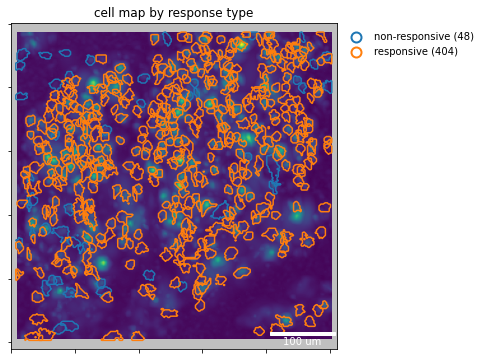

In [32]:
figs['cellmap'] = plot_cell_map(
    ROI_masks, trialavg_stats, s2p_ops, title='cell map by response type',
    um_per_px=daq_settings['micronsPerPixel'], refkey='Vcorr', mode='contour')

### Response strength (peak-zscore) dependency on cell response type

 10/05/2022 12:41:00: sub-indexing data...
 10/05/2022 12:41:00: filtering data...
 10/05/2022 12:41:00: cross-checking filters...
 10/05/2022 12:41:00: grouping by response type, averaging, estimating confidence intervals and plotting mean relative Z(ΔF/F0) change vs. P (MPa) ...
 10/05/2022 12:41:01: sub-indexing data...
 10/05/2022 12:41:01: filtering data...
 10/05/2022 12:41:01: cross-checking filters...
 10/05/2022 12:41:01: grouping by response type, averaging, estimating confidence intervals and plotting mean relative Z(ΔF/F0) change vs. DC (%) ...


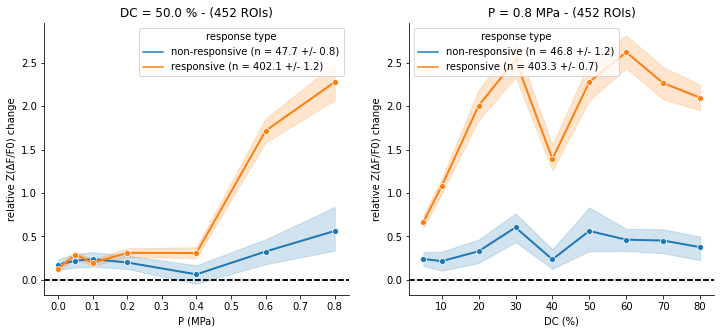

In [33]:
figs[f'{ykey_change} dependency'] = plot_stimparams_dependency_per_response_type(
    trialavg_stats, ykey_change, baseline=0)

### Merge timeseries and stats into single dataframe

In [34]:
logger.info('merging timeseries and stats information...')
plt_data = trialavg_xtimeseries.copy()
expand_and_add(trialavg_stats, plt_data)
data = add_time_to_table(plt_data)
plt_data

 10/05/2022 12:41:01: merging timeseries and stats information...
 10/05/2022 12:41:02: adding time info to table...


ΔF/F0  Z(ΔF/F0)   line  trial_length  duration (s)  P (MPa)  \
ROI run frame                                                                   
1   0   0      0.095187  0.217574  line3         100.0           0.2      0.0   
        1      0.094434  0.204379  line3         100.0           0.2      0.0   
        2      0.119183  0.638092  line3         100.0           0.2      0.0   
        3      0.116972  0.599334  line3         100.0           0.2      0.0   
        4      0.109815  0.473919  line3         100.0           0.2      0.0   
...                 ...       ...    ...           ...           ...      ...   
878 14  95     0.070463  0.074247  line3         100.0           0.2      0.8   
        96     0.061146 -0.113059  line3         100.0           0.2      0.8   
        97     0.059315 -0.149881  line3         100.0           0.2      0.8   
        98     0.058543 -0.165406  line3         100.0           0.2      0.8   
        99     0.068072  0.026176  line3         100.0           0.2      0.8   

               DC (%)  run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
ROI run frame                                                   
1   0   0        50.0   869.0        0.000000         0.00000   
        1        50.0   869.0        0.000000         0.00000   
        2        50.0   869.0        0.000000         0.00000   
        3        50.0   869.0        0.000000         0.00000   
        4        50.0   869.0        0.000000         0.00000   
...               ...     ...             ...             ...   
878 14  95       80.0   863.0       19.784475        15.82758   
        96       80.0   863.0       19.784475        15.82758   
        97       80.0   863.0       19.784475        15.82758   
        98       80.0   863.0       19.784475        15.82758   
        99       80.0   863.0       19.784475        15.82758   

               max pre-stim Z(ΔF/F0)  peak Z(ΔF/F0)  baseline Z(ΔF/F0)  \
ROI run frame                                                            
1   0   0                   0.555881       1.875157           0.122455   
        1                   0.555881       1.875157           0.122455   
        2                   0.555881       1.875157           0.122455   
        3                   0.555881       1.875157           0.122455   
        4                   0.555881       1.875157           0.122455   
...                              ...            ...                ...   
878 14  95                  0.519597       3.028329          -0.024634   
        96                  0.519597       3.028329          -0.024634   
        97                  0.519597       3.028329          -0.024634   
        98                  0.519597       3.028329          -0.024634   
        99                  0.519597       3.028329          -0.024634   

               relative Z(ΔF/F0) change  positive condition?  \
ROI run frame                                                  
1   0   0                      1.752701                 True   
        1                      1.752701                 True   
        2                      1.752701                 True   
        3                      1.752701                 True   
        4                      1.752701                 True   
...                                 ...                  ...   
878 14  95                     3.052962                 True   
        96                     3.052962                 True   
        97                     3.052962                 True   
        98                     3.052962                 True   
        99                     3.052962                 True   

               # positive conditions  responsive ROI? response type   time (s)  
ROI run frame                                                                   
1   0   0                         11             True    responsive  -2.808989  
        1                         11             True    responsive  -2.528090 

### Response type, pressure & duty cycle dependency, per category

 10/05/2022 12:41:02: sub-indexing data...
 10/05/2022 12:41:02: filtering data...
 10/05/2022 12:41:02: cross-checking filters...
 10/05/2022 12:41:02: grouping by response type, averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) vs. time (s) ...
 10/05/2022 12:41:08: sub-indexing data...
 10/05/2022 12:41:08: filtering data...
 10/05/2022 12:41:08: cross-checking filters...
 10/05/2022 12:41:08: grouping by response type, grouping by P (MPa), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) vs. time (s) ...
 10/05/2022 12:41:16: sub-indexing data...
 10/05/2022 12:41:16: filtering data...
 10/05/2022 12:41:16: cross-checking filters...
 10/05/2022 12:41:16: grouping by response type, grouping by DC (%), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) vs. time (s) ...


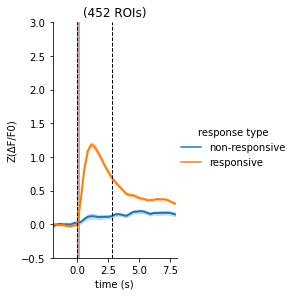

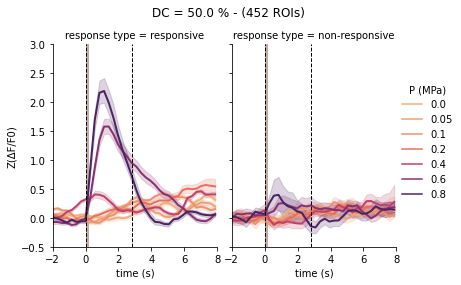

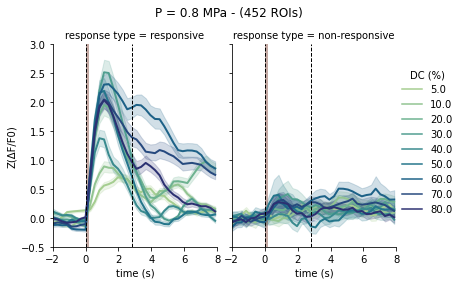

In [35]:
tracekwargs = dict(
    tbounds = [-2, 8.],  # s
    ybounds = {
        Label.ZSCORE: [-.5, 3.],
        Label.DFF: [0, .25]
        }[ykey_processing],   # y-axis unit
    height = 4,  # height of each figure axis
    aspect = 0.7,  # width / height aspect ratio of each axis
)
# Across conditions
figs[f'responses {ykey_processing} by type'] = plot_responses(
    plt_data, ykey=ykey_processing, hue=Label.ROI_RESP_TYPE, 
    hue_order=get_default_rtypes(), **tracekwargs)
# Pressure dependency
figs[f'responses {ykey_processing} by type DC={DC_REF}%'] = plot_responses(
    plt_data, ykey=ykey_processing, DC=DC_REF, hue=Label.P, 
    col=Label.ROI_RESP_TYPE, **tracekwargs)
# Duty cycle dependency
figs[f'responses {ykey_processing} by type P={P_REF}MPa'] = plot_responses(
    plt_data, ykey=ykey_processing, P=P_REF, hue=Label.DC, 
    col=Label.ROI_RESP_TYPE, **tracekwargs)

### Save figures

In [36]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, prefix=figsprefix)

# Save stacks as GIFs if specified
if irun_inspect is not None and save_gifs:
    #raw and fileted stacks from specific run
    save_stack_to_gif(
        figsdir, {'raw': raw_stack_fpaths[irun_inspect], 'filtered': filtered_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run)
    # registered stack (slice corresponding to specific run)
    save_stack_to_gif(
        figsdir, s2p_ops, title=outstack_label,
        ilabels=istimframes_stacked, bounds=runbounds)

 10/05/2022 12:41:28: saving figure "dataset_info" on page 0
 10/05/2022 12:41:28: saving figure "registered_offsets" on page 1
 10/05/2022 12:41:28: saving figure "phasecorrpeak_over_time" on page 2
 10/05/2022 12:41:28: saving figure "PCdrifts" on page 3
 10/05/2022 12:41:28: saving figure "registered_images" on page 4
 10/05/2022 12:41:28: saving figure "sparse_maps" on page 5
 10/05/2022 12:41:28: saving figure "identified_ROIs" on page 6
 10/05/2022 12:41:29: saving figure "ROI_prob_dists" on page 7
 10/05/2022 12:41:29: saving figure "protocol_summary" on page 8
 10/05/2022 12:41:29: saving figure "vdisp_profiles" on page 9
 10/05/2022 12:41:29: saving figure "peakvdisp_map" on page 10
 10/05/2022 12:41:29: saving figure "peakvdisp_vs_stimparams" on page 11
 10/05/2022 12:41:29: saving figure "motionreject_map" on page 12
 10/05/2022 12:41:29: saving figure "prestim max dist" on page 13
 10/05/2022 12:41:33: saving figure "pct_prestim_activity_map" on page 14
 10/05/2022 12:41:33

### Notify upon completion

In [37]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'notebook completed in {tstamp_end - tstamp_start} s'
jupyter_slack.notify_self(s)
logger.info(s)

 10/05/2022 12:41:36: notebook completed in 0:01:23.968247 s
